In [1]:
import os
import joblib
import utils_model
import pandas as pd
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### Data Loading

In [2]:
data_path = os.path.join('..', 'data', 'AS24_prepro_product_tier.csv')
data_case_study = pd.read_csv(data_path)
data_case_study.dropna(subset=['detail_views', 'search_views', 'cal_ctr'], inplace=True)
data_case_study = data_case_study.set_index('article_id')
data_case_study.tail()

,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,cal_ctr
article_id,,,,,,,,,,,,
348704581,Basic,Lexus,15740,8,2014,12.07.18,19.10.18,6895.0,230.0,99,0.03335750543872371,0.03336
359231940,Basic,Hyundai,2950,6,2006,28.09.18,23.10.18,1175.0,16.0,25,0.012936170212765956,0.01362
362425932,Basic,Volkswagen,7850,8,2014,04.11.18,21.11.18,448.0,21.0,16,0.046875,0.04688
357164227,Basic,Toyota,13945,5,2011,04.09.18,02.10.18,1617.0,29.0,28,0.017934446505875078,0.01793
353639932,Basic,Volkswagen,38800,7,2018,08.08.18,09.08.18,55.0,2.0,1,0.03454545454545454,0.03636


In [3]:
len(data_case_study)

78297

### Feature Encoding

In [35]:
ord_enc = OrdinalEncoder()
data_case_study["make_name"] = ord_enc.fit_transform(data_case_study[["make_name"]])

### Feature and Target selection

In [36]:
feature_cols = ['make_name', 'first_registration_year', 'price', 'search_views', 
                'detail_views', 'stock_days', 'cal_ctr']
target_col = ['product_tier']
X_data = data_case_study[feature_cols]
Y_data = data_case_study[target_col]

### Train and Test split

In [37]:
X_train, X_test, y_train, y_test = utils_model.split_train_test(X_data, Y_data)

### Implementation - Grid Search

In [25]:
param_grid = {
    'objective':['multiclass'],
    'num_class':[3],
    'n_estimators': list(range(200, 800, 200)),
    'boosting_type': ['gbdt', 'rf'],
    'num_leaves': list(range(10, 100, 20)),
    'learning_rate': [0.01, 0.1],
    'subsample_for_bin': [20000, 30000],
    'min_child_samples': [20, 50],
    'colsample_bytree': [0.6, 0.8],
    "max_depth": [5, 10],
    "metric":['softmax']
}

In [28]:
%%time
lgbm_classifier = LGBMClassifier()
lgbm_cv = GridSearchCV(lgbm_classifier, param_grid, cv=5, verbose=1) 
lgbm_cv.fit(X_train.values, y_train.product_tier.values) 
lgbm_cv.best_params_ 

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
CPU times: total: 15h 50min 27s
Wall time: 1h 22min 51s


{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_depth': 5,
 'metric': 'softmax',
 'min_child_samples': 50,
 'n_estimators': 400,
 'num_class': 3,
 'num_leaves': 10,
 'objective': 'multiclass',
 'subsample_for_bin': 30000}

### Defining LightGBM model with fine-tune hyperparamters

In [29]:
lgbm_tuned = LGBMClassifier(boosting_type = 'gbdt',
                            n_estimators = 400,
                            num_class = 3,
                            colsample_bytree = 0.6,
                            learning_rate = 0.1,
                            max_depth = 5,
                            metric = 'softmax',
                            min_child_samples = 50,
                            num_leaves = 10,
                            subsample_for_bin = 30000) 

### Model Training

In [30]:
lgbm_tuned.fit(X_train.values, y_train.product_tier.values)
joblib.dump(lgbm_tuned, os.path.join('..', 'trained_models', 'lgbm_classifier.pkl'))

['..\\trained_models\\lgbm_classifier.pkl']

### Model Prediction

In [31]:
gbm_classifier = joblib.load(os.path.join('..', 'trained_models', 'lgbm_classifier.pkl'))
y_test_pred = gbm_classifier.predict(X_test.values)

### Model Performance

Accuracy of the model = 97.2


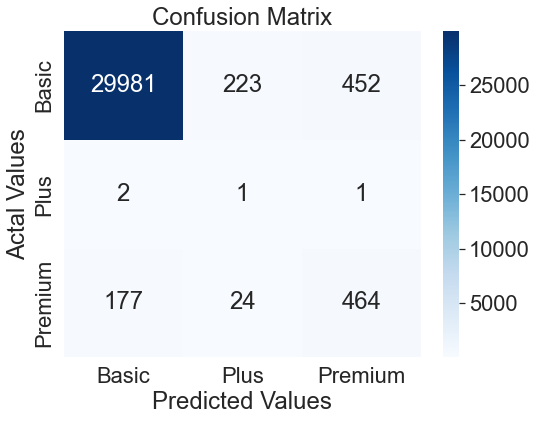

,precision,recall,f1-score,support
Basic,0.99,0.98,0.99,30656
Plus,0.00,0.25,0.01,4
Premium,0.51,0.70,0.59,665
accuracy,0.97,0.97,0.97,0
macro avg,0.50,0.64,0.53,31325
weighted avg,0.98,0.97,0.98,31325


In [32]:
utils_model.generate_performance_metrics(y_test.product_tier.values, y_test_pred)

### Performance Explainability
* As we noticed a high imbalance in the category of product_tier the results are biased due to it. We can see that the accuracy of model is close to 97%  but the precision and recall suffers by a large margin.

* We can simply say that, although the model is trained for a multiclass classification problem but it performs like a binary classifier. Where it predicts the product_tier Basic with the highest accuracy but cannot predict the other groups with same efficiency.

### What could be done
* Use SMOTE method to oversample the minority class and balance the dataset. Retrain the model with this modified dataset to assess the actual performance of the developed model. This was feasible to do in the given time frame and it has been implemented below.

* Develop 2 models i.e model-A as a binary classifier that initially splits the prediction into the product_tier Basic and Other (Plus and Premium). Then model-B as another binary classifier for the Other group.
This will not be feasible for larger number of groups.



### Training, Prediction and Performace analysis over Balanced Dataset using SMOTE

In [38]:
oversample = SMOTE()
sm = SMOTE(random_state=42)
X_data_bal, Y_data_bal = sm.fit_resample(X_data, Y_data)

In [39]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = utils_model.split_train_test(X_data_bal, 
                                                                                Y_data_bal)

In [40]:
lgbm_tuned.fit(X_train_bal.values, y_train_bal.product_tier.values)
joblib.dump(lgbm_tuned, os.path.join('..', 'trained_models', 'lgbm_balanced_classifier.pkl'))

['..\\trained_models\\lgbm_balanced_classifier.pkl']

In [43]:
balanced_gbm_classifier = joblib.load(os.path.join('..', 'trained_models', 
                                                  'lgbm_balanced_classifier.pkl'))
y_test_pred_bal = balanced_gbm_classifier.predict(X_test_bal.values)

Accuracy of the model = 89.6


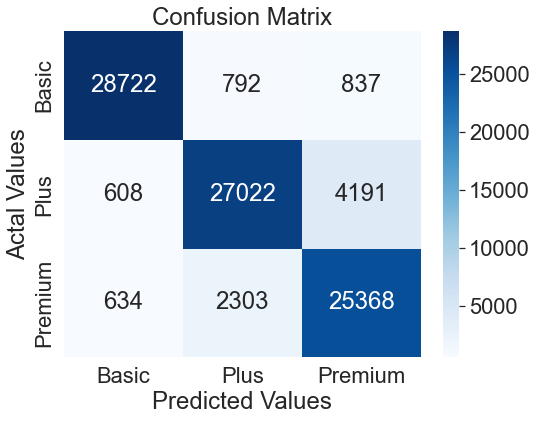

,precision,recall,f1-score,support
Basic,0.96,0.95,0.95,30351
Plus,0.90,0.85,0.87,31821
Premium,0.83,0.90,0.86,28305
accuracy,0.90,0.90,0.90,0
macro avg,0.90,0.90,0.90,90477
weighted avg,0.90,0.90,0.90,90477


In [44]:
utils_model.generate_performance_metrics(y_test_bal.product_tier.values, y_test_pred_bal)